In [2]:
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('all.csv')

**Hypothesis**: `cgroups` can guarantee isolation for concurrent workloads that put limits on direct IO bandwidth, assuming an over-provisioned scenario.

**Workloads**: `read`, `write` and `randomread` concurrent tasks for 4, 256 and 4096 KB.

**Baseline**: Run each workload without concurrency for 4KB block size and use this as the overprovisioned maximum bandwidth capacity of the device.

----------

Let's look at the baseline first:

In [51]:
df.groupby('mode').maxbw.unique()

mode
randread      [299]
read        [26194]
write       [15397]
Name: maxbw, dtype: object

In [8]:
df.head()

,repetition,blksize_kb,limits_pct,mode,maxbw,limit,benchmark,job,read_bw,write_bw
0,3,256,"40,25,25",write,15397,6158,fio,write-sdb-256k-seq,0,6157
1,3,256,"40,25,25",read,26194,6548,fio,read-sdb-256k-seq,6547,0
2,3,256,"40,25,25",randread,299,74,fio,randread-sdb-256k-seq,74,0
3,3,256,"25,40,25",write,15397,3849,fio,write-sdb-256k-seq,0,3848
4,3,256,"25,40,25",read,26194,10477,fio,read-sdb-256k-seq,10475,0


In [15]:
def normalize_wrt_limit(x):
    v = x['write_bw'] if 'write' in x['mode'] else x['read_bw']
    return v / float(x['limit'])

df['result_normalized'] = df.apply(normalize_wrt_limit, axis=1)

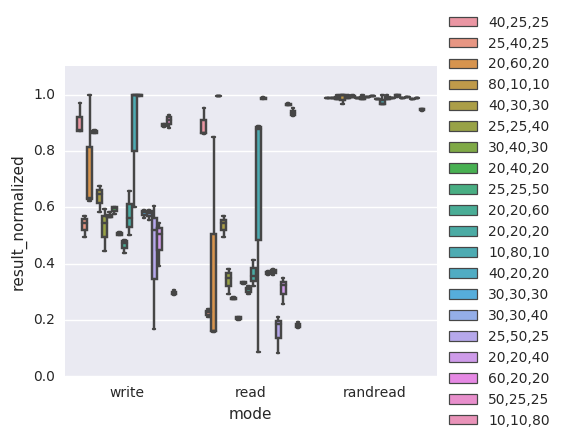

In [54]:
ax = sns.boxplot(x='mode', y='result_normalized', data=df.query("blksize_kb == 4"), hue='limits_pct')
ax.set(ylim=(0, 1.1))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

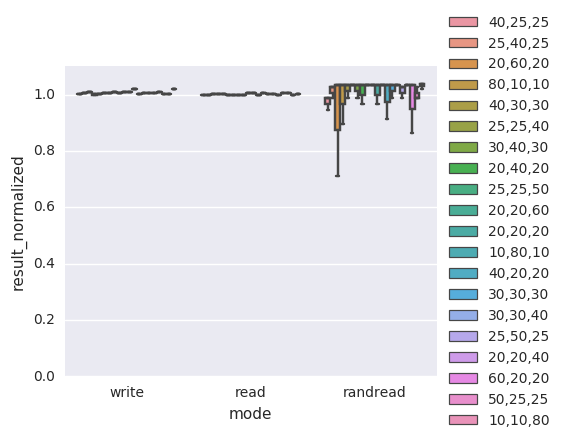

In [52]:
ax = sns.boxplot(x='mode', y='result_normalized', data=df.query("blksize_kb == 4096"), hue='limits_pct')
ax.set(ylim=(0, 1.1))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

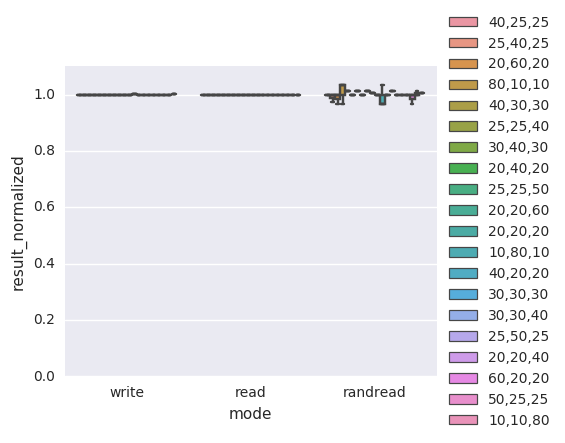

In [53]:
ax = sns.boxplot(x='mode', y='result_normalized', data=df.query("blksize_kb == 256"), hue='limits_pct')
ax.set(ylim=(0, 1.1))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Our results show that when block size is distinct to 4KB, we can guarantee performance for 3 concurrent IO workloads. We then codify this validation so we can test it:

In [98]:
for bs in ['4', '256', '4096']:
    within_range = df.query("blksize_kb == " + bs).groupby('limits_pct')['result_normalized'].median().between(0.95, 1.05).all()
    if bs == '4':
        print(not within_range)
    else:
        print(within_range)



True
True
True
